In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

In [2]:
peak_folder = '/Users/emiliebertholet/cernbox/coldbox_data/selected_waveforms'

with open(f'{peak_folder}/selection_cosmics_wlenNone_prom500.pkl', 'rb') as file:
    dic = pickle.load(file)
cosmics = pd.DataFrame(dic)
print(f"cosmics:  {cosmics.shape[0]} peaks, {cosmics.trigger_record.unique().shape[0]} trigger records")

with open(f'{peak_folder}/selection_PNS_wlenNone_prom500.pkl', 'rb') as file:
    dic = pickle.load(file)
PNS = pd.DataFrame(dic)
print(f"PNS:  {PNS.shape[0]} peaks, {PNS.trigger_record.unique().shape[0]} trigger records")

with open(f'{peak_folder}/selection_PNS_neutrons_wlenNone_prom500.pkl', 'rb') as file:
    dic = pickle.load(file)
PNS_neutrons = pd.DataFrame(dic)
print(f"PNS_neutrons:  {PNS_neutrons.shape[0]} peaks, {PNS_neutrons.trigger_record.unique().shape[0]} trigger records")

with open(f'{peak_folder}/selection_PNS_SideBand_wlenNone_prom500.pkl', 'rb') as file:
    dic = pickle.load(file)
PNS_SB = pd.DataFrame(dic)
print(f"PNS_SB:  {PNS_SB.shape[0]} peaks, {PNS_SB.trigger_record.unique().shape[0]} trigger records")


# cosmics, 25150 peaks, 4189 trigger records
# PNS, 46228 peaks, 14283 trigger records
# PNS_neutrons, 3780 peaks, 3187 trigger records
# PNS_SB, 39102 peaks, 13893 trigger records



# cosmics.keys()

cosmics:  25150 peaks, 4189 trigger records
PNS:  46228 peaks, 14283 trigger records
PNS_neutrons:  3780 peaks, 3187 trigger records
PNS_SB:  39102 peaks, 13893 trigger records


In [ ]:
def pad_waveforms(input_data, pad_length=500):
    output_data = input_data
    output_data['waveform_padded'] = [np.pad(wf, (0, pad_length - len(wf))) if len(wf) < pad_length else wf[:pad_length] for wf in output_data['waveform']]
    return output_data

cosmics      = pad_waveforms(cosmics, 500)
PNS          = pad_waveforms(PNS, 500)
PNS_neutrons = pad_waveforms(PNS_neutrons, 500)
PNS_SB       = pad_waveforms(PNS_SB, 500)

In [5]:
## make sure it works as expected
train_percentage = 0.9
tot_size = len( cosmics['waveform_padded'] )
train_size = int( np.ceil(len( cosmics['waveform_padded'] )*train_percentage))
print(f"total size = {tot_size}")
print(f'\ntraining size = {train_size}')
print(f'test size = {tot_size - (train_size)}')
len(cosmics['waveform_padded'])

X_train =  np.stack( cosmics['waveform_padded'][:train_size])
X_test  = np.stack( cosmics['waveform_padded'][(train_size):])

print(f'\ntraining size = {len(X_train)}')
print(f'test size = {len(X_test)}')

total size = 25150

training size = 22635
test size = 2515

training size = 22635
test size = 2515


# Training

In [9]:
# Create an OCSVM model
# check documentation for list of kernels and parameters
## https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html
# ocsvm = OneClassSVM(nu=0.1, kernel='rbf', verbose=True, shrinking=False) 

ocsvm = OneClassSVM(nu=0.01, kernel='rbf', verbose=True, shrinking=False) 



In [10]:
# Train the model
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_train)
ocsvm.fit(X_train)

[LibSVM]*
optimization finished, #iter = 273
obj = 4337.958894, rho = 42.855146
nSV = 234, nBSV = 219


OneClassSVM(nu=0.01, shrinking=False, verbose=True)

In [11]:
print("Training sample shape", X_train.shape)
print("Hyperparameters:")
print("nu:", ocsvm.nu)
print("kernel:", ocsvm.kernel)
## more stuff
support_vectors = ocsvm.support_vectors_
print("Number of support vectors:", support_vectors.shape[0])

Training sample shape (22635, 500)
Hyperparameters:
nu: 0.01
kernel: rbf
Number of support vectors: 234


# Validation

In [12]:

def print_info(y_pred, verbose=True):
    # predict: Returns -1 for outliers and 1 for inliers.
    Ntot = y_pred.shape[0]
    Nanomalies = (y_pred == -1).sum()
    if verbose: print(f'total number of waveforms: {Ntot}')
    if verbose: print(f'number of outliers detected: {Nanomalies} -> {Nanomalies*100/Ntot:.2f} %')
    return Ntot, Nanomalies



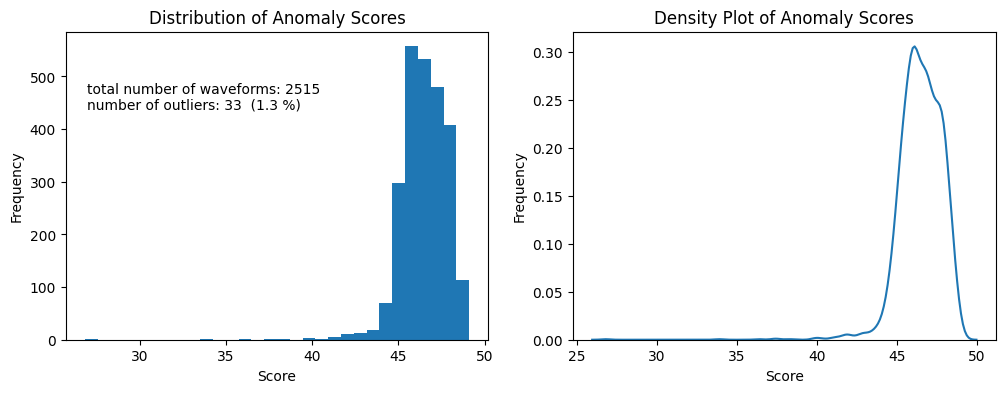

In [13]:
y_pred = ocsvm.predict(X_test) 
Ntot, Nanomalies = print_info(y_pred, False)
LLH = ocsvm.score_samples(X_test) ## get log-likelihood of a data point under the learned density model
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax = axs[0]
ax.hist(LLH, bins=30)
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')
ax.set_title(f'Distribution of Anomaly Scores');
# ax.text(0.05, 0.85, f'{file}', transform=ax.transAxes);
ax.text(0.05, 0.8, f'total number of waveforms: {Ntot}', transform=ax.transAxes);
ax.text(0.05, 0.75, f'number of outliers: {Nanomalies}  ({Nanomalies*100/Ntot:.1f} %)', transform=ax.transAxes);
ax = axs[1]
sns.kdeplot(LLH)
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')
ax.set_title('Density Plot of Anomaly Scores');

# Inference

In [14]:
PNS_test  = np.stack( PNS['waveform_padded'])
print(f'PNS test size = {len(PNS_test)}')

PNS_n_test  = np.stack( PNS_neutrons['waveform_padded'])
print(f'PNS neutrons test size = {len(PNS_n_test)}')

PNS_SB_test  = np.stack( PNS_SB['waveform_padded'])
print(f'PNS side band test size = {len(PNS_SB_test)}')



PNS test size = 46228
PNS neutrons test size = 3780
PNS side band test size = 39102


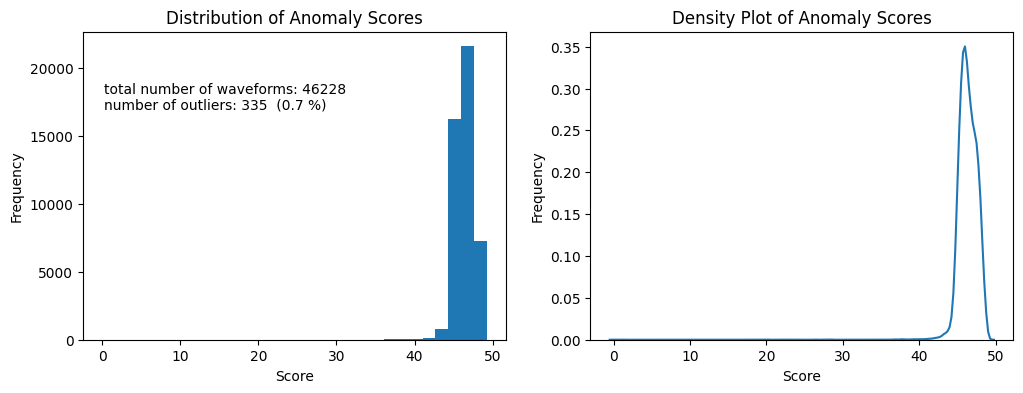

In [15]:
test_sample = PNS_test
y_pred = ocsvm.predict(test_sample) 
Ntot, Nanomalies = print_info(y_pred, False)
LLH = ocsvm.score_samples(test_sample) ## get log-likelihood of a data point under the learned density model
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax = axs[0]
ax.hist(LLH, bins=30)
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')
ax.set_title(f'Distribution of Anomaly Scores');
# ax.text(0.05, 0.85, f'{file}', transform=ax.transAxes);
ax.text(0.05, 0.8, f'total number of waveforms: {Ntot}', transform=ax.transAxes);
ax.text(0.05, 0.75, f'number of outliers: {Nanomalies}  ({Nanomalies*100/Ntot:.1f} %)', transform=ax.transAxes);
ax = axs[1]
sns.kdeplot(LLH)
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')
ax.set_title('Density Plot of Anomaly Scores');

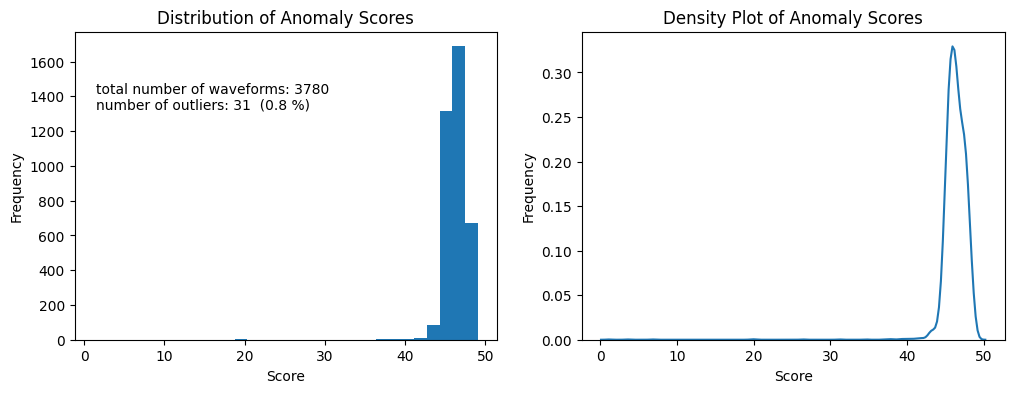

In [16]:
test_sample = PNS_n_test
y_pred = ocsvm.predict(test_sample) 
Ntot, Nanomalies = print_info(y_pred, False)
LLH = ocsvm.score_samples(test_sample) ## get log-likelihood of a data point under the learned density model
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax = axs[0]
ax.hist(LLH, bins=30)
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')
ax.set_title(f'Distribution of Anomaly Scores');
# ax.text(0.05, 0.85, f'{file}', transform=ax.transAxes);
ax.text(0.05, 0.8, f'total number of waveforms: {Ntot}', transform=ax.transAxes);
ax.text(0.05, 0.75, f'number of outliers: {Nanomalies}  ({Nanomalies*100/Ntot:.1f} %)', transform=ax.transAxes);
ax = axs[1]
sns.kdeplot(LLH)
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')
ax.set_title('Density Plot of Anomaly Scores');

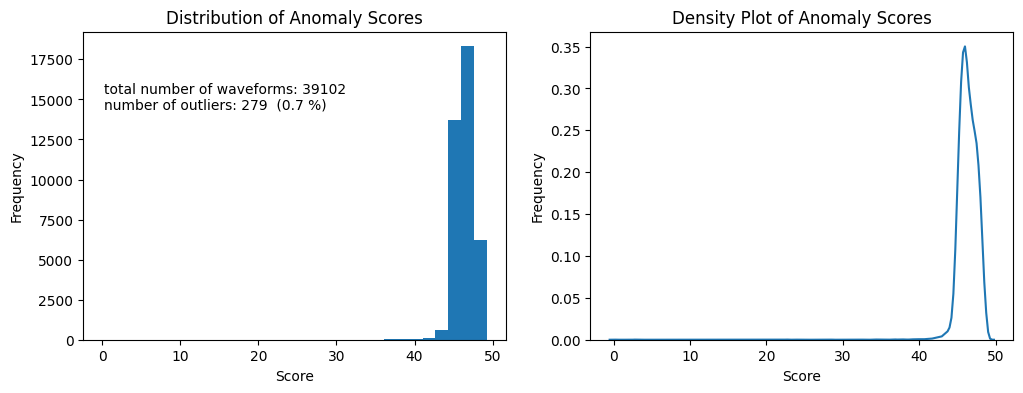

In [17]:
test_sample = PNS_SB_test
y_pred = ocsvm.predict(test_sample) 
Ntot, Nanomalies = print_info(y_pred, False)
LLH = ocsvm.score_samples(test_sample) ## get log-likelihood of a data point under the learned density model
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax = axs[0]
ax.hist(LLH, bins=30)
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')
ax.set_title(f'Distribution of Anomaly Scores');
# ax.text(0.05, 0.85, f'{file}', transform=ax.transAxes);
ax.text(0.05, 0.8, f'total number of waveforms: {Ntot}', transform=ax.transAxes);
ax.text(0.05, 0.75, f'number of outliers: {Nanomalies}  ({Nanomalies*100/Ntot:.1f} %)', transform=ax.transAxes);
ax = axs[1]
sns.kdeplot(LLH)
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')
ax.set_title('Density Plot of Anomaly Scores');